<a href="https://colab.research.google.com/github/gkar90/Tensorflow-Tree-Cover-Classification/blob/main/Real_Forest_Classifier_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Overview:

Dataset pulled from:

**US Forest Service - GeoData - Tree Cover Canopy Dataset**

https://data.fs.usda.gov/geodata/rastergateway/treecanopycover/



In this project, we're going to get information from the US Forest Services GeoData to determine if we could predict the the type of forest cover (most common kind of tree cover) only based off the datasets cartographic variables they provided. 

The datasets include four wilderness areas located in the Roosevelt National Forest of Northern Colorado. The areas represent forests with minimal human-caused disturbances, so existing forest cover types are mainly a result of ecological processes rather than human forest management practices. 

## Import the Modules

First thing to do is import the modules we're going to be working with

In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
%matplotlib inline

## Import the Dataset

Now import the data we'll work with

In [2]:
#uploaded locally
data = pd.read_csv("cover_data.csv")

## Data Analysis and Cleanup

Let's look through the data and see what we're working with 

In [34]:
data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,class
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [35]:
data.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,class
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,0.448865,0.051434,0.436074,0.063627,0.005217,0.012952,0.008301,0.021335,0.002749,0.011316,0.000181,0.000308,0.001974,0.056168,0.021359,0.051584,0.030001,0.001031,0.000005,0.004897,0.005890,0.003268,0.006921,0.015936,0.001442,0.057439,0.099399,0.036622,0.000816,0.004456,0.001869,0.001628,0.198356,0.051927,0.044175,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060,2.051471
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,0.497379,0.220882,0.495897,0.244087,0.072039,0.113066,0.090731,0.144499,0.052356,0.105775,0.013442,0.017550,0.044387,0.230245,0.144579,0.221186,0.170590,0.032092,0.002272,0.069804,0.076518,0.057077,0.082902,0.125228,0.037950,0.232681,0.299197,0.187833,0.028551,0.066605,0.043193,0.040318,0.398762,0.221879,0.205483,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791,1.396504
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

#### Quick Analysis

Just quick look at some of the information above:



1.   The inputs are every column to the left of "Class", and the thing we are going to try to predict is "Class" -> located in the last column
2.   Almost 600,000 data points, which is great for creating a training set and a test set
3.   No non-null values which makes modeling easier. Don't need to remove NaN's or fill NaN's with any values
4.   All values are numeric (int64 to be specific). Helps in pre-processing since don't need to change any strings to ints, etc...
5.   Important thing to note is that `Wilderness_Area` and `Soil_Type` are categorical, meaning value of either 0 or 1 (0 if False, 1 if True).

Since the data is fairly clean, we can take a look at everything visually and see if we can see any trends right off the bat. Maybe can see things like: is there any correlation between class and elevation? or class and slope?



In [40]:
elevation = data.Elevation
elevation.head()

0    2596
1    2590
2    2804
3    2785
4    2595
Name: Elevation, dtype: int64

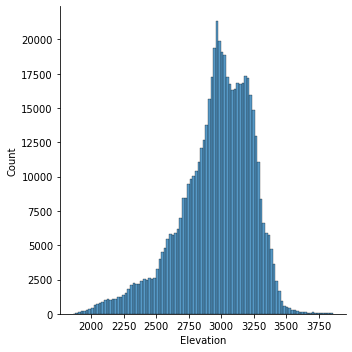

In [41]:
sns.displot(elevation, bins = 100)
#ok so elevation is left-skewed. lets see what slope looks like

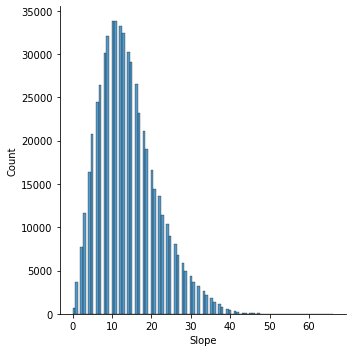

In [42]:
sns.displot(data.Slope, bins = 100)
#slope is right-skewed. most is around 12. lets see all of them now

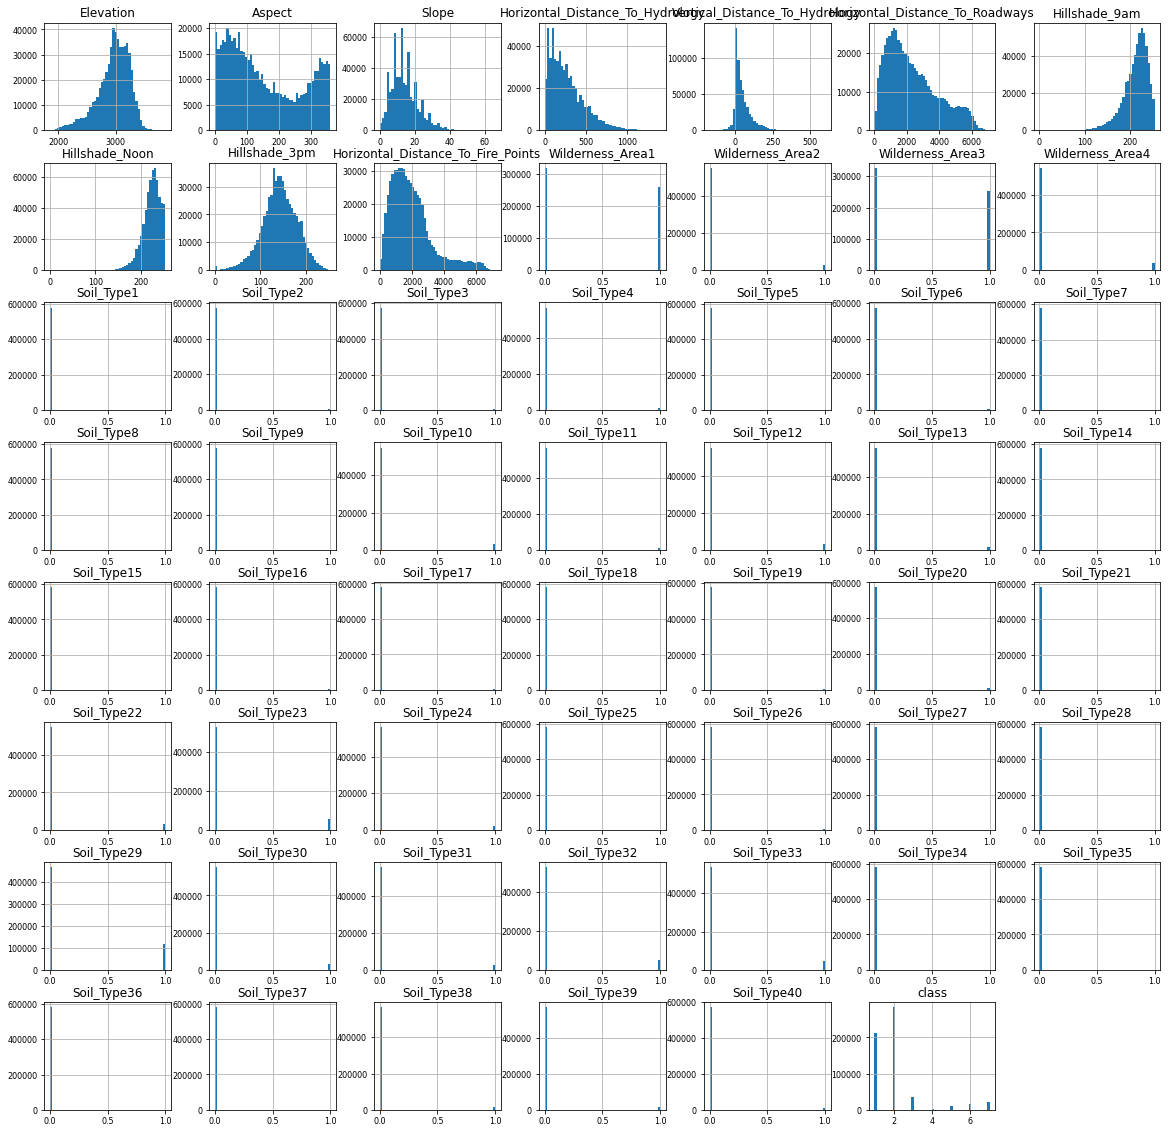

In [44]:
data.hist(figsize=(20,20), bins = 50, xlabelsize= 8, ylabelsize= 8);

#### Quick Analysis 2

So we confirm that Wilderness_Area and Soil_type are categorical. Let's just see the non-categorical variables

In [45]:
non_binary = data[['Elevation', 'Aspect', 'Slope', 
                   'Horizontal_Distance_To_Hydrology', 
                   'Vertical_Distance_To_Hydrology', 
                   'Horizontal_Distance_To_Roadways', 
                   'Hillshade_9am', 'Hillshade_Noon', 
                   'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'class']]

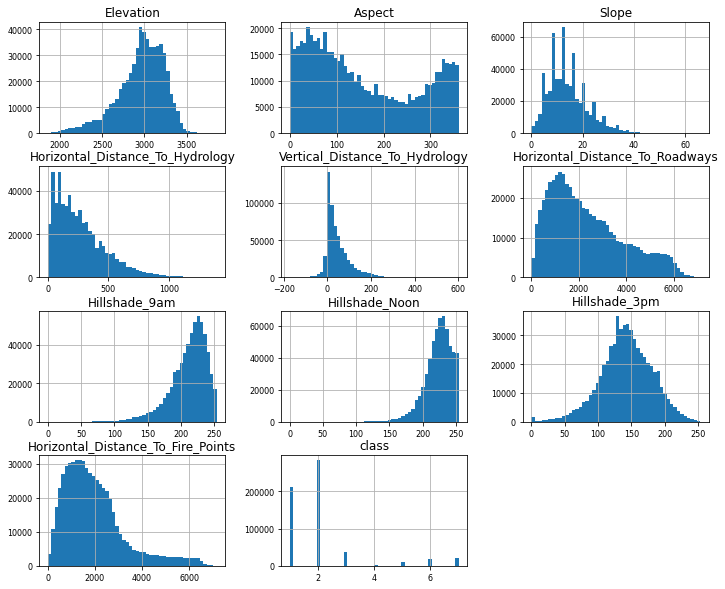

In [49]:
non_binary.hist(figsize= (12, 10), bins = 50, xlabelsize= 8, ylabelsize= 8);

#### Quick Analysis 3

Cool, so obviously not a super detailed picture, but we have an idea of how the non-categorical values break down. We can now try to see if there's any sort of correlations anywhere

In [61]:
# any corr to elevation?
data_corr = non_binary.corr()['class'][:-1]
data_corr


Elevation                            -0.269554
Aspect                                0.017080
Slope                                 0.148285
Horizontal_Distance_To_Hydrology     -0.020317
Vertical_Distance_To_Hydrology        0.081664
Horizontal_Distance_To_Roadways      -0.153450
Hillshade_9am                        -0.035415
Hillshade_Noon                       -0.096426
Hillshade_3pm                        -0.048290
Horizontal_Distance_To_Fire_Points   -0.108936
Name: class, dtype: float64

So overall, nothing huge here. Class has a slight negative correlation with elevation while most are around the zero mark. 


## Start Modeling

Here we can start our modeling process...from pre-processing the data to fitting the model:

### Pre-process the Data

So one thing we see is that the scales are all out of whack. The elevation goes from 0-300 while the horizontal distances go from 0-7000, so we need to pre-process our data to get everything on the right scale.

In [3]:
#scale and split the data
def scale_and_split(data, scaler, test_size, random_state):
  features = data.iloc[:, :-1]
  labels = data.iloc[:, -1]

  features_train, features_test, labels_train, labels_test = train_test_split(features, 
                                                                              labels, 
                                                                              test_size = test_size,
                                                                              random_state = random_state)
  
  scaler = scaler

  f_train_scaled = scaler.fit_transform(features_train)
  f_test_scaled = scaler.transform(features_test)

  return f_train_scaled, f_test_scaled, labels_train, labels_test


In [4]:
f_train_scaled, f_test_scaled, labels_train, labels_test = scale_and_split(data, StandardScaler(), 0.2, 42)

Perfect. We have our data right now split into scaled train and test sets. Now can start working on the model



### Create the Model

Start to build out our structure/neural network

In [69]:
def get_model(features_train, learning_rate):
  #first we instantiate the model
  model = Sequential()

  #add our input layer
  model.add(InputLayer(input_shape = (features_train.shape[1], )))

  #add our hidden layers
  model.add(Dense(64, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(8, activation='relu'))

  #add our output layer
  model.add(Dense(8, activation='softmax'))

  #create our optimizers and metrics and compile the model
  opt=Adam(learning_rate = learning_rate)
  model.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = opt)

  #lastly, see the model summary and return the mode
  model.summary()
  return model


### Fit the Model

Now fit what we just modeled

In [72]:
def fit_model(X_train, Y_train, learning_rate, num_epochs, num_batch_size):
  #first we get our model
  model = get_model(X_train, learning_rate)

  #now we create our early-stop so we do not iterate through all epochs if unnecessary
  #I'm choosing a patience of 10 since we will probably choose 200+ epochs (based off 600K datapoints)
  earlystop = EarlyStopping(monitor='val_accuracy', verbose = 1, patience = 10)

  #now fit the model:
  fit_mod = model.fit(X_train, Y_train, epochs = num_epochs, batch_size = num_batch_size, verbose = 1, validation_split = 0.1, callbacks = [earlystop])

  return fit_mod

In [71]:
our_fit_model = fit_model(f_train_scaled, labels_train, 0.01, 200, 2048)
#we have 600K inputs, so batch size of 2048 makes sense since there's so many data points
#choosing 200 epochs so we make sure our learning is run over enough times
#learning rate of 0.01 as a standard

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 64)                3520      
_________________________________________________________________
dense_21 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_22 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_23 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_24 (Dense)             (None, 8)                 72        
Total params: 6,336
Trainable params: 6,336
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
205/205 [==============================] - 2s 9ms/step - loss: 0.8743 - accuracy: 0.6660 - val_loss: 0.553

#### Quick Analysis

Awesome. Model worked perfectly:
1.   Our model took in 6000 parameters which is the right amount for my laptop to process. 
> Of course, it is more efficient to have more parameters as we can produce better results, but due to having a weak computer, the max parameters we look to process here is ~5,000.
2.   Our early stop worked perfectly
> Looks like our loss is around .3 and our accuracy is around .9. Not bad results for only ~6,000 parameters







### Visualize our Model

Let's see what our model has produced.

In [75]:
def accuracy_visualization(fit_model):
  fig = plt.figure(figsize = (20, 15))
  ax1 = fig.add_subplot(2, 1, 1)
  ax1.plot(fit_model.history['accuracy'])
  ax1.plot(fit_model.history['val_accuracy'])
  ax1.set_title('Model Accuracy')
  ax1.set_ylabel("Accuracy")
  ax1.set_xlabel("Number of Epochs")
  ax1.legend(['Train', 'Test'], loc = 'upper left')

  ax2 = fig.add_subplot(2, 1, 2)
  ax2.plot(fit_model.history['loss'])
  ax2.plot(fit_model.history['val_loss'])
  ax2.set_title("Model's Learning Curve")
  ax2.set_ylabel("Loss")
  ax2.set_xlabel("Number of Epochs")
  ax2.legend(['Train', 'Test'], loc = 'upper left')

  fig.tight_layout()

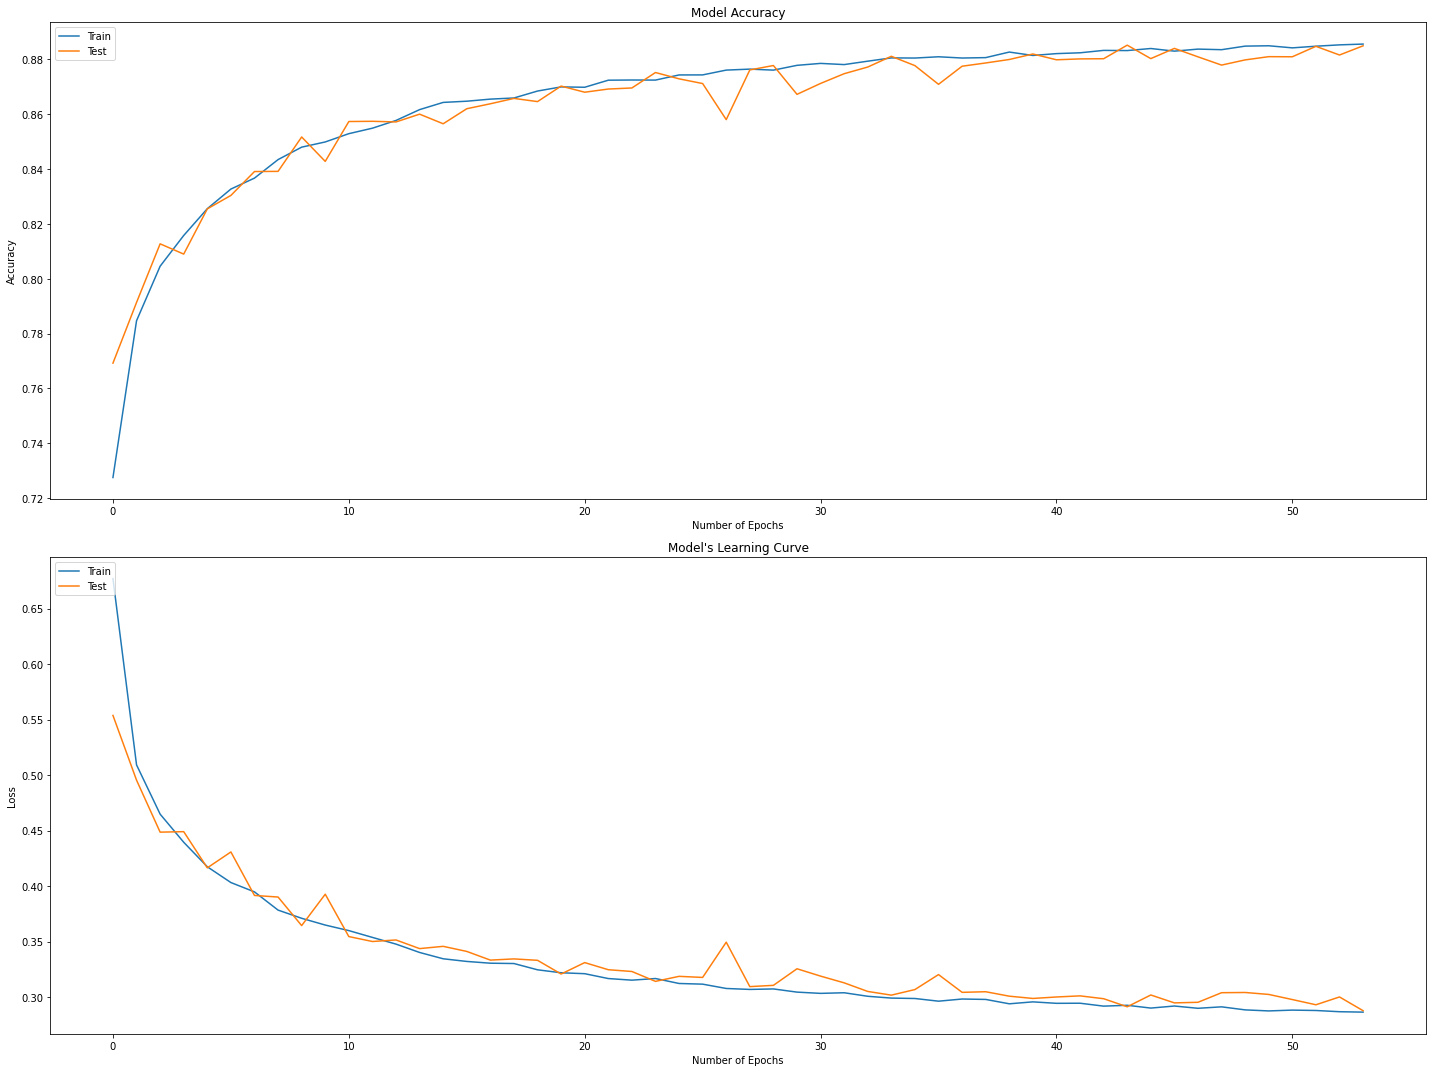

In [76]:
model_visualization = accuracy_visualization(our_fit_model)

Awesome...we've got a decent accuracy, and we've got a decent loss. let's see the overall classification report so we can see the precision, recall, and f1.

In [94]:
#lets create a function that gives us a classification report

def class_report(model, features_test, labels_test, class_names):
  #first thing i want to do is get the models score, even before doing anything:
  score = model.evaluate(features_test, labels_test, verbose = 0)
  print(""" 
  Test Loss: {}
  Test Accuracy: {}""".format(score[0], score[1]))

  #now, lets get our predicted labels for the test set to compare to the actual labels
  y_predicted = model.predict(features_test)
  y_predicted = np.argmax(y_predicted, axis = 1)

  print("The classification report for our report is: ")
  print(classification_report(labels_test, y_predicted, target_names = class_names))

  #can return the y_predicted so that can use it in our confusion matrix later
  return y_predicted


In [95]:
classes_cover = ["Spruce/Fir", 
                 "Lodgepole Pine", 
                 "Ponderosa Pine", 
                 "Cottonwood/Willow", 
                 "Aspen", 
                 "Douglas-fir", 
                 "Krumholz"]

class_report = class_report(our_fit_model.model, f_test_scaled, labels_test, classes_cover)

 
  Test Loss: 0.29087966680526733
  Test Accuracy: 0.8838067650794983
The classification report for our report is: 
                   precision    recall  f1-score   support

       Spruce/Fir       0.88      0.88      0.88     42557
   Lodgepole Pine       0.89      0.91      0.90     56500
   Ponderosa Pine       0.88      0.86      0.87      7121
Cottonwood/Willow       0.84      0.60      0.70       526
            Aspen       0.72      0.65      0.68      1995
      Douglas-fir       0.76      0.72      0.74      3489
         Krumholz       0.90      0.86      0.88      4015

         accuracy                           0.88    116203
        macro avg       0.84      0.78      0.81    116203
     weighted avg       0.88      0.88      0.88    116203



#### Quick Analysis

Awesome. We can see the classication report for each class and see how accurate everything was.

Spruce, Lodgepole Pine, and Krumholz are producing pretty high precision, recall, and f1-scores. This means its predicting pretty accuratly the True Positives. 

Cottonwood/Willow, Aspen, and Douglas-fir are a little bit lower, especially Cottonwood/Willow and Aspen have a recall in the 60% range, meaning they're True Predictions versus the total Cottonwood/Willow and Aspen inputs is only 60% correct. 

Overall - we've produced a pretty accurate model. the macro-F1 is about 80% which is great for a relatively small neural network. 

Let's create our confusion matrix now, and see it visually

In [87]:
def visualize_cm(y_true, y_predicted, class_names):
  con_matrix = confusion_matrix(y_true, y_predicted)
  fig, ax = plt.subplots(figsize = (20, 15))
  heatmap = sns.heatmap(con_matrix, fmt='g', cmap='Blues', annot=True, ax=ax)
  ax.set_title("Confusion Matrix")
  ax.set_ylabel("True Class")
  ax.set_xlabel("Predicted Class")
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)


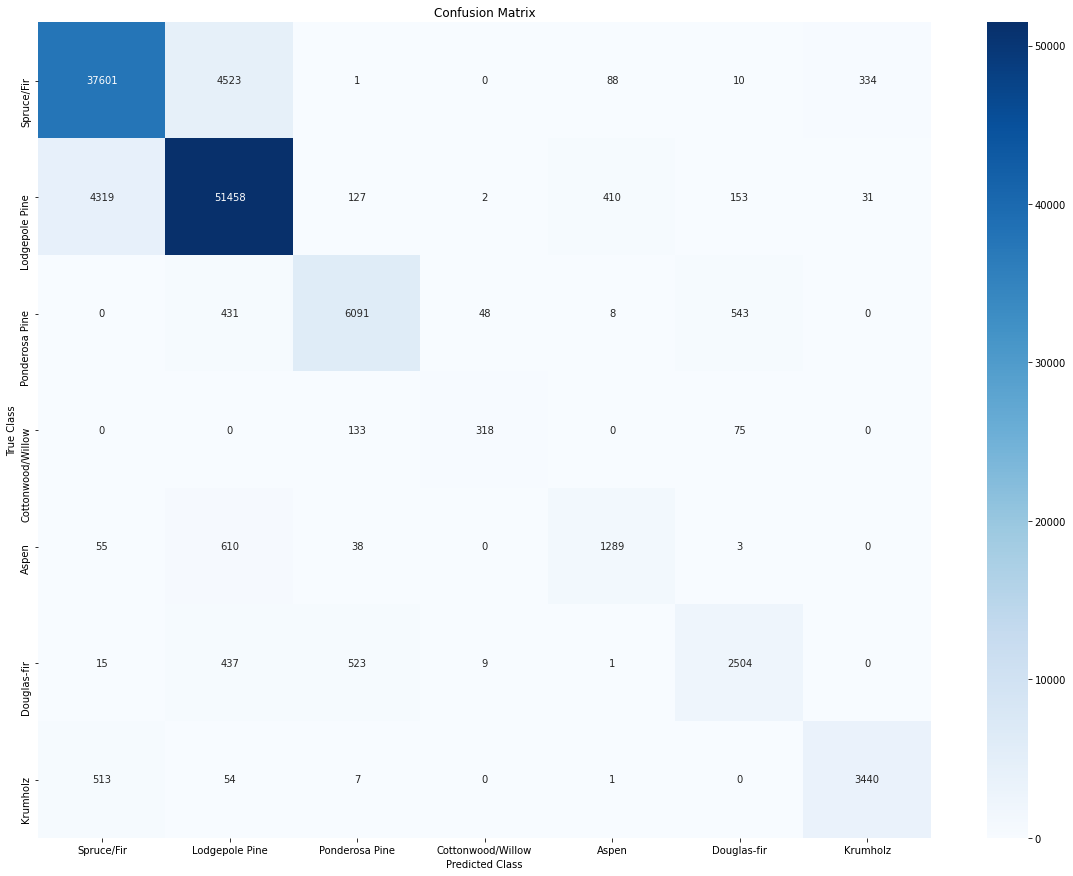

In [88]:
con_matrix = visualize_cm(labels_test, class_report, classes_cover)


#### Quick Analysis 2

So we see from the classification report, and the confusion matrix (visually looking at the heatmap), that the Lodgepole Pine, Spruce/Fir, and Ponderosa Pine were the most accurately predicted.

Pretty good results...

In [96]:
### jst to see...exactly what is the breakdown of cover types in our data set:
data['class'].value_counts()

2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: class, dtype: int64

## Conclusions

The numbers within the diagonal of the heatmap show exactly how many predictions were actually correctly classified. The numbers on the outside of those diagonals show the mis-classification of the inputs.

Ways we can improve on the model are:
1.   Check the proportions of each cover type
> It makes sense that we're accurately predicted Lodgepole Pine and Cottonwood Willow. Looking at the value counts above of the cover types, we see that almost 500,000 of the 600,000 covers were either Lodgepole or Cottonwood. The data is _heavily imbalanced_ towards those two.  
2.   See if there is any input that is causing the model to trip-up. Could look futher into the correlations and see if removing any of the inputs could give us a better result
3.   Work on getting better sampled data where we have more classifications other than Lodgepole Pine and Cottonwood Willow
4.   Tweak our hyperparameters to create a more efficient model
> Again, we can tweak things like the learning rate, the number of epochs, and the batch size in order to get better results. We can also add more hidden layers and can also add Dropout to see if we get better results. Due to working on an old laptop, this is the best we will do for now.


Overall - having a macro-F1 score of 80% and an accuracy of 90%, I feel pretty confident in rolling out this model for development/future use.